# 4.2 腫瘍数の比較

## インポート・設定

In [1]:
import dataclasses
import warnings
from numbers import Number

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown
from scipy import signal, special, stats

sns.set_theme()
warnings.simplefilter("ignore")
SEED = 0

## a

In [2]:
@dataclasses.dataclass
class CountData:
    """カウントデータを格納するクラス"""

    data: np.ndarray

A系統、B系統の腫瘍数の観察データ

<Axes: >

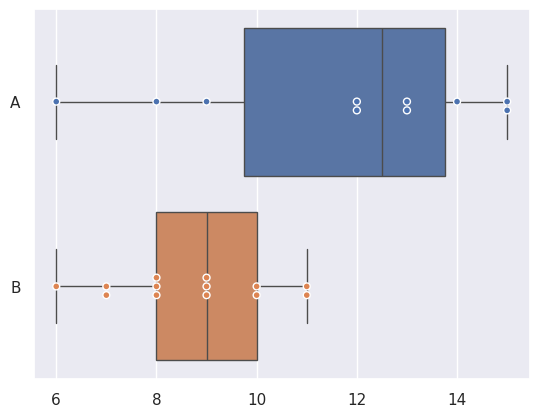

In [11]:
# データ定義
y_a = CountData(data=np.array([12, 9, 12, 14, 13, 13, 15, 8, 15, 6]))
y_b = CountData(data=np.array([11, 11, 10, 9, 9, 8, 7, 10, 6, 8, 8, 9, 7]))

# 可視化
data = {"A": y_a.data, "B": y_b.data}
_ = sns.boxplot(data, orient="h", fill=True)
_ = sns.swarmplot(data, orient="h", edgecolor="w", linewidth=1.0)

与えられた事前分布

$$
\theta _A \sim \text{gamma}(120, 10), \quad
\theta _B \sim \text{gamma}(12, 1), \quad
p(\theta _A, \theta _B) = p(\theta _A) \times p(\theta _B)
$$

から事後分布を求める。

In [4]:
@dataclasses.dataclass
class GammaDist:
    """ガンマ分布のパラメータを格納するクラス"""

    a: Number
    b: Number

    def sample(self, size) -> np.ndarray:
        return stats.gamma.rvs(a=self.a, scale=1 / self.b, size=size, random_state=SEED)


def get_poisson_model_posterior(y, a_prior, b_prior):

    # 事後分布のパラメータ
    a_posterior = a_prior + np.sum(y)
    b_posterior = b_prior + len(y)

    return GammaDist(a=a_posterior, b=b_posterior)

In [5]:
posterior_A = get_poisson_model_posterior(y_a.data, a_prior=120, b_prior=10)
posterior_B = get_poisson_model_posterior(y_b.data, a_prior=12, b_prior=1)

print("Posterior of A:", posterior_A)
print("Posterior of B:", posterior_B)

Posterior of A: GammaDist(a=237, b=20)
Posterior of B: GammaDist(a=125, b=14)


事後分布からサンプリングを行い、 $Pr(\theta _A < \theta _B | y_A, y_B)$ の近似値を求める。

In [6]:
size = 5000
df_sample = pd.DataFrame(
    {
        "thetaA": posterior_A.sample(size),
        "thetaB": posterior_B.sample(size),
    }
)

df_sample.describe()

,thetaA,thetaB
count,5000.000000,5000.000000
mean,11.837982,8.915820
std,0.752776,0.781226
min,9.411076,6.464044
25%,11.323739,8.379315
50%,11.807916,8.878416
75%,12.328013,9.420318
max,15.005056,12.293829


サンプリングした値の分布を可視化してみる

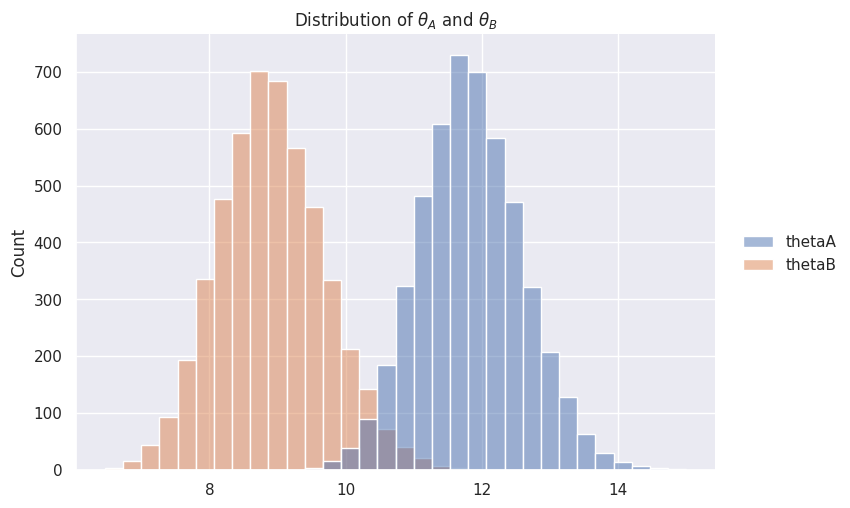

In [7]:
# 事後分布の可視化
g = sns.displot(
    df_sample,
    aspect=1.5,
)
_ = g.set(title=r"Distribution of $\theta_A$ and $\theta_B$")

$Pr(\theta _A < \theta _B | y_A, y_B) \approx 0$ となる。

In [8]:
df_sample["thetaA"].lt(df_sample["thetaB"]).mean()

0.0

## b

In [9]:
def get_proba_by_mc(n0: int):
    # 事後分布
    posterior_A = get_poisson_model_posterior(y_a.data, a_prior=120, b_prior=10)
    posterior_B = get_poisson_model_posterior(y_b.data, a_prior=12 * n0, b_prior=n0)

    # モンテカルロサンプリング
    # thetaAとthetaBは独立なので、thetaAのサンプリング結果は使いまわしても良いが、ここでは毎回サンプリングしている。
    size = 5000
    df_sample = pd.DataFrame(
        {
            "thetaA": posterior_A.sample(size),
            "thetaB": posterior_B.sample(size),
        }
    )

    # thetaB < thetaAの確率の近似値
    proba = df_sample["thetaA"].lt(df_sample["thetaB"]).mean()

    return proba

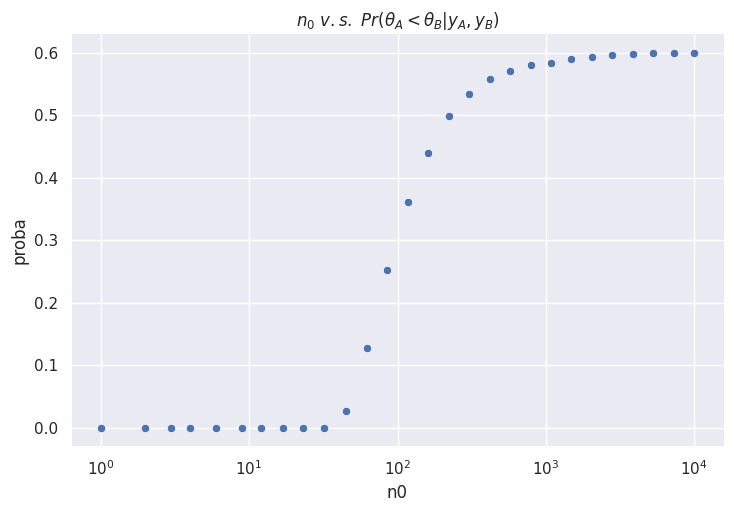

In [10]:
# n0 = 1 ~ 10000でサンプリングする
df_proba = pd.DataFrame({"n0": np.floor(np.logspace(0, 4, 30))})
df_proba["proba"] = df_proba["n0"].apply(get_proba_by_mc)

g = sns.relplot(
    df_proba,
    x="n0",
    y="proba",
    aspect=1.5,
)
_ = g.set(xscale="log", title=r"$n_0 ~ v.s. ~ Pr(\theta_A < \theta_B| y_A, y_B)$")

- $n_0 = 10$ 付近までは確率はほぼゼロである。
    - $n_0$が小さいときは事前分布よりデータを重視している。
    - Aの事後平均(237 / 20 = 11.85)よりBの標本平均(~8.7)が小さい。
    - A, Bの事後標準偏差はともに1未満であり、これは事後平均の差より小さい。
    - 以上の理由から$n_0$が小さいときは$\theta_B$が大きい確率はほほゼロになる。
- $n_0 = 100$ 付近で確率が0.3近くなり、$n_0 = 1000$ 付近では0.6近くなる。
    - $n_0$が大きいときはデータより事前分布を重視している。
    - Aの事後平均(237 / 20 = 11.85)よりBの事前平均(=12)が大きい。
    - 以上の理由から$n_0$が大きいときは$\theta_B$が大きい確率が0.5を超える。